# 🚀 XGBoost with Cross-Validation
## 5-Fold Cross-Validation for All Sampling Techniques
### Results: mean ± std

In [1]:
# ============================================================================
# Cell 1: Import Libraries
# ============================================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import warnings
from collections import Counter, defaultdict

from sklearn.model_selection import (
    RandomizedSearchCV, StratifiedKFold, cross_validate, cross_val_score
)
from sklearn.metrics import (
    make_scorer, precision_score, recall_score, f1_score,
    accuracy_score, roc_auc_score, average_precision_score,
    confusion_matrix, roc_curve, balanced_accuracy_score,
    matthews_corrcoef, brier_score_loss, classification_report
)

# ⭐ สำคัญ! ใช้ Pipeline จาก imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours, NearMiss
from imblearn.combine import SMOTEENN, SMOTETomek
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')
print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
# ============================================================================
# Cell 2: Setup Directories & Global Variables
# ============================================================================

base_path = 'XGBoost_CV_Results'
model_dir = os.path.join(base_path, 'models')
results_dir = os.path.join(base_path, 'results')
os.makedirs(model_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

# Global storage
cv_results_all = {}  # เก็บผล CV แต่ละเทคนิค
test_results_all = {}  # เก็บผล Test แต่ละเทคนิค
best_models = {}  # เก็บ best model แต่ละเทคนิค

# Cross-Validation config
N_SPLITS = 5  # 5-Fold CV
N_ITER = 50  # RandomizedSearchCV iterations
RANDOM_STATE = 42

print(f'✅ Created directories:')
print(f'   Models: {model_dir}')
print(f'   Results: {results_dir}')
print(f'\n✅ Configuration:')
print(f'   Cross-Validation Folds: {N_SPLITS}')
print(f'   RandomizedSearchCV iterations: {N_ITER}')
print(f'   Random State: {RANDOM_STATE}')

✅ Created directories:
   Models: XGBoost_CV_Results/models
   Results: XGBoost_CV_Results/results

✅ Configuration:
   Cross-Validation Folds: 5
   RandomizedSearchCV iterations: 50
   Random State: 42


In [3]:
# ============================================================================
# Cell 3: Load Data
# ============================================================================

# ⚠️ แก้ path ให้ถูกต้องตามระบบของคุณ
data_train = pd.read_csv('heart_disease_preprocessed_imput_train.csv')
data_test  = pd.read_csv('heart_disease_preprocessed_imput_test.csv')

TARGET_COL = 'Heart Disease Status'

X_train = data_train.drop(columns=[TARGET_COL])
y_train = data_train[TARGET_COL].astype(int)

X_test  = data_test.drop(columns=[TARGET_COL])
y_test  = data_test[TARGET_COL].astype(int)

print('✅ Data loaded successfully!')
print(f'   Training samples: {len(X_train)}')
print(f'   Test samples: {len(X_test)}')
print(f'   Features: {X_train.shape[1]}')
print(f'\n📊 Class distribution (train):', Counter(y_train))
print(f'📊 Class distribution (test):', Counter(y_test))

✅ Data loaded successfully!
   Training samples: 8000
   Test samples: 2000
   Features: 27

📊 Class distribution (train): Counter({0: 6400, 1: 1600})
📊 Class distribution (test): Counter({0: 1600, 1: 400})


In [4]:
# ============================================================================
# Cell 3.5: DIAGNOSTIC - Check Data Quality
# ============================================================================

print("\n" + "="*80)
print("🔍 DATA QUALITY CHECK")
print("="*80)

# 1. Class distribution
print("\n1️⃣ Class Distribution:")
print(f"   Class 0: {(y_train==0).sum()} samples ({(y_train==0).sum()/len(y_train)*100:.2f}%)")
print(f"   Class 1: {(y_train==1).sum()} samples ({(y_train==1).sum()/len(y_train)*100:.2f}%)")

imbalance_ratio = (y_train==0).sum() / (y_train==1).sum()
print(f"\n   Imbalance Ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 10:
    print("   ⚠️ SEVERE IMBALANCE! (>10:1)")
    print("   → Recommendation: Use class_weight instead of resampling")
elif imbalance_ratio > 3:
    print("   ⚠️ HIGH IMBALANCE (>3:1)")
    print("   → Recommendation: Use conservative sampling")
else:
    print("   ✓ Moderate imbalance")

# 2. Feature statistics
print("\n2️⃣ Feature Statistics:")
print(f"   Number of features: {X_train.shape[1]}")
print(f"   Missing values: {X_train.isnull().sum().sum()}")

# 3. Minimum viable samples
min_samples = 50  # minimum for class 1
print(f"\n3️⃣ Minimum Samples Check:")
print(f"   Class 1 samples: {(y_train==1).sum()}")
if (y_train==1).sum() < min_samples:
    print(f"   ⚠️ WARNING: Very few class 1 samples! (<{min_samples})")
    print("   → ENN/Tomek may remove ALL class 1 samples!")
else:
    print(f"   ✓ Sufficient class 1 samples (>{min_samples})")

print("\n" + "="*80)


🔍 DATA QUALITY CHECK

1️⃣ Class Distribution:
   Class 0: 6400 samples (80.00%)
   Class 1: 1600 samples (20.00%)

   Imbalance Ratio: 4.00:1
   ⚠️ HIGH IMBALANCE (>3:1)
   → Recommendation: Use conservative sampling

2️⃣ Feature Statistics:
   Number of features: 27
   Missing values: 0

3️⃣ Minimum Samples Check:
   Class 1 samples: 1600
   ✓ Sufficient class 1 samples (>50)



In [5]:
# ============================================================================
# Cell 4: Analyze Class Distribution & Calculate Weights
# ============================================================================

counter_train = Counter(y_train)
print("📊 TRAIN SET CLASS DISTRIBUTION:")
print(f"   Class 0 (No Disease): {counter_train[0]} ({counter_train[0]/len(y_train)*100:.1f}%)")
print(f"   Class 1 (Disease):    {counter_train[1]} ({counter_train[1]/len(y_train)*100:.1f}%)")

counter_test = Counter(y_test)
print("\n📊 TEST SET CLASS DISTRIBUTION:")
print(f"   Class 0 (No Disease): {counter_test[0]} ({counter_test[0]/len(y_test)*100:.1f}%)")
print(f"   Class 1 (Disease):    {counter_test[1]} ({counter_test[1]/len(y_test)*100:.1f}%)")

# Calculate class weights
majority_class = counter_train[0]
minority_class = counter_train[1]
imbalance_ratio = majority_class / minority_class
scale_pos_weight = imbalance_ratio

print("\n⚖️ CLASS WEIGHT CALCULATION:")
print(f"   Imbalance ratio: {imbalance_ratio:.2f}:1")
print(f"   Scale pos weight: {scale_pos_weight:.2f}")

if imbalance_ratio > 3:
    print("\n⚠️ WARNING: Severe class imbalance detected!")
elif imbalance_ratio > 1.5:
    print("\n⚠️ Moderate class imbalance detected")
else:
    print("\n✓ Classes are relatively balanced")

📊 TRAIN SET CLASS DISTRIBUTION:
   Class 0 (No Disease): 6400 (80.0%)
   Class 1 (Disease):    1600 (20.0%)

📊 TEST SET CLASS DISTRIBUTION:
   Class 0 (No Disease): 1600 (80.0%)
   Class 1 (Disease):    400 (20.0%)

⚖️ CLASS WEIGHT CALCULATION:
   Imbalance ratio: 4.00:1
   Scale pos weight: 4.00

⚠️ WARNING: Severe class imbalance detected!


In [6]:
# ============================================================================
# Cell 5: Helper Functions
# ============================================================================

def specificity_score(y_true, y_pred):
    """Calculate specificity (True Negative Rate)"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0.0

# สร้าง scorer สำหรับ specificity
specificity_scorer = make_scorer(specificity_score)

def get_cv_scorers():
    """Define all scoring metrics for cross-validation"""
    return {
        'accuracy': 'accuracy',
        'precision': make_scorer(precision_score, pos_label=1, zero_division=0),
        'recall': make_scorer(recall_score, pos_label=1, zero_division=0),
        'specificity': specificity_scorer,
        'f1': make_scorer(f1_score, pos_label=1, zero_division=0),
        'roc_auc': 'roc_auc',
        'average_precision': 'average_precision',
        'balanced_accuracy': 'balanced_accuracy',
    }

def summarize_cv_results(cv_results, method_name):
    """
    Summarize cross-validation results as mean ± std
    
    Parameters:
    -----------
    cv_results : dict
        Results from cross_validate
    method_name : str
        Name of the method
    
    Returns:
    --------
    summary : dict
        Summary statistics
    """
    summary = {'method': method_name}
    
    # Test scores
    for key in cv_results.keys():
        if key.startswith('test_'):
            metric_name = key.replace('test_', '')
            scores = cv_results[key]
            summary[f'{metric_name}_mean'] = np.mean(scores)
            summary[f'{metric_name}_std'] = np.std(scores)
            summary[f'{metric_name}_mean_std'] = f"{np.mean(scores):.4f} ± {np.std(scores):.4f}"
    
    # Fit time
    summary['fit_time_mean'] = np.mean(cv_results['fit_time'])
    summary['fit_time_std'] = np.std(cv_results['fit_time'])
    
    return summary

def print_cv_summary(summary):
    """Pretty print CV summary"""
    print(f"\n📊 Cross-Validation Results Summary")
    print("="*70)
    print(f"Method: {summary['method']}")
    print("="*70)
    
    metrics = ['accuracy', 'precision', 'recall', 'specificity', 'f1', 'roc_auc']
    for metric in metrics:
        mean_key = f'{metric}_mean'
        std_key = f'{metric}_std'
        if mean_key in summary:
            print(f"  {metric.capitalize():20s}: {summary[mean_key]:.4f} ± {summary[std_key]:.4f}")
    
    print(f"\n  Fit time: {summary['fit_time_mean']:.2f} ± {summary['fit_time_std']:.2f} seconds")


def print_training_classification_report(model, X, y, method_name):
    """Print a classification report for training predictions"""
    print(f"\n🧾 Training Classification Report ({method_name})")
    y_pred = model.predict(X)
    print(classification_report(y, y_pred, digits=4, zero_division=0))

print("✅ Helper functions defined!")

✅ Helper functions defined!


In [7]:
# ============================================================================
# Cell 6: Model & Sampling Setup (FIXED)
# ============================================================================

print("="*80)
print("🚀 XGBOOST SETUP WITH CROSS-VALIDATION (FIXED)")
print("="*80)

# คำนวณ imbalance ratio
from collections import Counter
counter = Counter(y_train)
imbalance_ratio = counter[0] / counter[1]

print(f"\n⚖️ Class Distribution:")
print(f"   Class 0: {counter[0]} samples ({counter[0]/len(y_train)*100:.1f}%)")
print(f"   Class 1: {counter[1]} samples ({counter[1]/len(y_train)*100:.1f}%)")
print(f"   Imbalance Ratio: {imbalance_ratio:.2f}:1")

# Base XGBoost for No Sampling (uses scale_pos_weight)
base_xgb_nosamp = XGBClassifier(
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric="logloss",
    use_label_encoder=False,
    scale_pos_weight=imbalance_ratio,  # 👈 FIX: ใช้ actual ratio
    reg_alpha=0.1,
    reg_lambda=1.0,
    gamma=0.1,
    min_child_weight=1,  # 👈 FIX: ลดจาก 3
    max_depth=5,         # 👈 FIX: เพิ่มจาก 4
    n_estimators=200     # 👈 FIX: เพิ่ม default
)

# Base XGBoost for Sampling methods (scale_pos_weight ลดลง)
base_xgb_samp = XGBClassifier(
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric="logloss",
    use_label_encoder=False,
    scale_pos_weight=max(1.0, imbalance_ratio / 2),  # 👈 FIX: ใช้ครึ่งหนึ่ง
    reg_alpha=0.1,
    reg_lambda=1.0,
    gamma=0.1,
    min_child_weight=1,  # 👈 FIX: ลดจาก 3
    max_depth=5,         # 👈 FIX: เพิ่มจาก 4
    n_estimators=200     # 👈 FIX: เพิ่ม default
)

print(f"\n✅ Base Models Created:")
print(f"   base_xgb_nosamp: scale_pos_weight = {imbalance_ratio:.2f}")
print(f"   base_xgb_samp: scale_pos_weight = {max(1.0, imbalance_ratio/2):.2f}")

# Parameter grid for RandomizedSearchCV (FIXED)
PARAM_GRID_XGB = {
    'clf__n_estimators': [100, 200, 300, 500],           # 👈 FIX: เพิ่ม 500
    'clf__max_depth': [4, 5, 6, 7],                      # 👈 FIX: เพิ่ม 7
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__subsample': [0.7, 0.8, 0.9, 1.0],
    'clf__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'clf__min_child_weight': [1, 2, 3],                  # 👈 FIX: เพิ่ม 1, 2
    'clf__gamma': [0, 0.1, 0.2],
    'clf__reg_alpha': [0, 0.1, 0.5],
    'clf__reg_lambda': [0.5, 1.0, 2.0],
    'clf__scale_pos_weight': [1, 3, 5, 10, imbalance_ratio]  # 👈 FIX: เพิ่มตัวนี้!
}

# Create StratifiedKFold for CV
cv_splitter = StratifiedKFold(
    n_splits=N_SPLITS,
    shuffle=True,
    random_state=RANDOM_STATE
)

print(f"\n✅ Parameter grid: {len(PARAM_GRID_XGB)} parameters")
print(f"✅ CV Splitter: {N_SPLITS}-Fold StratifiedKFold")
print(f"✅ Setup Complete!")

🚀 XGBOOST SETUP WITH CROSS-VALIDATION (FIXED)

⚖️ Class Distribution:
   Class 0: 6400 samples (80.0%)
   Class 1: 1600 samples (20.0%)
   Imbalance Ratio: 4.00:1

✅ Base Models Created:
   base_xgb_nosamp: scale_pos_weight = 4.00
   base_xgb_samp: scale_pos_weight = 2.00

✅ Parameter grid: 10 parameters
✅ CV Splitter: 5-Fold StratifiedKFold
✅ Setup Complete!


In [8]:
# ============================================================================
# Cell 7: CV Training - No Sampling (FIXED v2)
# ============================================================================

print("\n" + "="*80)
print("🚀 METHOD 1/9: No Sampling (CRITICAL FIX)")
print("="*80)

method_name = "No Sampling"

# Pipeline (No Sampling)
pipe = Pipeline([
    ("clf", base_xgb_nosamp)
])

# ============================================================================
# Step 1: RandomizedSearchCV เพื่อหา best parameters
# ============================================================================
print("\n⏳ Step 1: Finding best parameters with RandomizedSearchCV...")

# 🔥 FIX: ใช้ balanced_accuracy แทน f1
grid_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=PARAM_GRID_XGB,
    n_iter=N_ITER,
    scoring='balanced_accuracy',  # 🔥 เปลี่ยนจาก 'f1'
    cv=cv_splitter,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    return_train_score=False
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\n✅ Best parameters found:")
for param, value in best_params.items():
    print(f"   {param}: {value}")
print(f"\n✅ Best CV Balanced Accuracy: {best_score:.4f}")

# 🔥 เช็คว่า scale_pos_weight ที่เลือกเป็นเท่าไหร่
selected_weight = best_params.get('clf__scale_pos_weight', 'not tuned')
print(f"\n📊 Selected scale_pos_weight: {selected_weight}")

# ============================================================================
# Step 2: Cross-Validation ด้วย best model
# ============================================================================
print(f"\n⏳ Step 2: Running {N_SPLITS}-Fold Cross-Validation with best params...")

best_pipe = grid_search.best_estimator_

# Run cross-validation with multiple metrics
scorers = get_cv_scorers()

cv_results = cross_validate(
    estimator=best_pipe,
    X=X_train,
    y=y_train,
    cv=cv_splitter,
    scoring=scorers,
    return_train_score=False,
    n_jobs=-1,
    verbose=0
)

# Summarize results
summary = summarize_cv_results(cv_results, "No Sampling")
cv_results_all["No Sampling"] = {
    'cv_results': cv_results,
    'summary': summary,
    'best_params': best_params
}

# Print summary
print_cv_summary(summary)

# 🔥 เพิ่มการเช็ค sanity
print("\n⚠️ SANITY CHECK:")
if summary['specificity_mean'] < 0.1:
    print("   ❌ WARNING: Specificity too low! Model predicts mostly class 1!")
    print("   → Reduce scale_pos_weight further")
elif summary['recall_mean'] < 0.1:
    print("   ❌ WARNING: Recall too low! Model predicts mostly class 0!")
    print("   → Increase scale_pos_weight")
else:
    print("   ✅ Model seems balanced")

# ============================================================================
# Step 3: Train final model บน full training set
# ============================================================================
print("\n⏳ Step 3: Training final model on full training set...")

final_model = grid_search.best_estimator_
final_model.fit(X_train, y_train)
print_training_classification_report(final_model, X_train, y_train, method_name)


# Save model
model_path = os.path.join(model_dir, f"XGB_No_Sampling_final.pkl")
joblib.dump(final_model, model_path)
print(f"✅ Model saved: XGB_No_Sampling_final.pkl")

# Store best model
best_models["No Sampling"] = final_model

print("\n" + "="*80)
print(f"✅ {method_name} - COMPLETE!")
print("="*80)


🚀 METHOD 1/9: No Sampling (CRITICAL FIX)

⏳ Step 1: Finding best parameters with RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:13:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:13:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:13:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:13:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use


✅ Best parameters found:
   clf__subsample: 0.8
   clf__scale_pos_weight: 4.0
   clf__reg_lambda: 2.0
   clf__reg_alpha: 0.5
   clf__n_estimators: 300
   clf__min_child_weight: 2
   clf__max_depth: 7
   clf__learning_rate: 0.01
   clf__gamma: 0.2
   clf__colsample_bytree: 0.8

✅ Best CV Balanced Accuracy: 0.5106

📊 Selected scale_pos_weight: 4.0

⏳ Step 2: Running 5-Fold Cross-Validation with best params...


/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:14:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:14:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:14:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:14:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use


📊 Cross-Validation Results Summary
Method: No Sampling
  Accuracy            : 0.6936 ± 0.0089
  Precision           : 0.2170 ± 0.0256
  Recall              : 0.2056 ± 0.0366
  Specificity         : 0.8156 ± 0.0129
  F1                  : 0.2108 ± 0.0302
  Roc_auc             : 0.5087 ± 0.0255

  Fit time: 1.27 ± 0.03 seconds

⚠️ SANITY CHECK:
   ✅ Model seems balanced

⏳ Step 3: Training final model on full training set...
✅ Model saved: XGB_No_Sampling_final.pkl

✅ No Sampling - COMPLETE!


In [9]:
# ============================================================================
# Cell 8: CV Training - SMOTE
# ============================================================================

print("\n" + "="*80)
print("🚀 METHOD 2/9: SMOTE")
print("="*80)

method_name = "SMOTE"

# สร้าง sampler
sampler = SMOTE(
    sampling_strategy=0.4,  # 👈 สร้าง class 1 ให้ได้ 30% ของ class 0
    k_neighbors=5,
    random_state=42
)
# เพิ่มหลังจาก resampling
if sampler is not None:
    X_temp, y_temp = sampler.fit_resample(X_train, y_train)
    
    # 🔍 เช็ค distribution หลัง resampling
    print(f"\n📊 After {method_name}:")
    print(f"   Total samples: {len(y_temp)}")
    print(f"   Class 0: {(y_temp==0).sum()} ({(y_temp==0).sum()/len(y_temp)*100:.1f}%)")
    print(f"   Class 1: {(y_temp==1).sum()} ({(y_temp==1).sum()/len(y_temp)*100:.1f}%)")
    
    # ⚠️ เช็คว่า class 1 เหลือไหม
    if (y_temp==1).sum() < 10:
        print(f"   ⚠️ WARNING: Too few class 1 samples! ({(y_temp==1).sum()})")

# สร้าง pipeline
pipe = Pipeline([
    ("sampler", sampler),
    ("clf", base_xgb_samp)
])

# ============================================================================
# Step 1: RandomizedSearchCV เพื่อหา best parameters
# ============================================================================
print("\n⏳ Step 1: Finding best parameters with RandomizedSearchCV...")

grid_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=PARAM_GRID_XGB,
    n_iter=N_ITER,
    scoring='f1',
    cv=cv_splitter,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    return_train_score=False
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\n✅ Best parameters found:")
for param, value in best_params.items():
    print(f"   {param}: {value}")
print(f"\n✅ Best CV F1 Score: {best_score:.4f}")

# ============================================================================
# Step 2: Cross-Validation ด้วย best model
# ============================================================================
print(f"\n⏳ Step 2: Running {N_SPLITS}-Fold Cross-Validation with best params...")

# สร้าง best pipeline
best_pipe = grid_search.best_estimator_

# Run cross-validation with multiple metrics
scorers = get_cv_scorers()

cv_results = cross_validate(
    estimator=best_pipe,
    X=X_train,
    y=y_train,
    cv=cv_splitter,
    scoring=scorers,
    return_train_score=False,
    n_jobs=-1,
    verbose=0
)

# Summarize results
summary = summarize_cv_results(cv_results, "SMOTE")
cv_results_all["SMOTE"] = {
    'cv_results': cv_results,
    'summary': summary,
    'best_params': best_params
}

# Print summary
print_cv_summary(summary)

# ============================================================================
# Step 3: Train final model บน full training set
# ============================================================================
print("\n⏳ Step 3: Training final model on full training set...")

final_model = grid_search.best_estimator_
final_model.fit(X_train, y_train)
print_training_classification_report(final_model, X_train, y_train, method_name)


# Save model
model_path = os.path.join(model_dir, f"XGB_SMOTE_final.pkl")
joblib.dump(final_model, model_path)
print(f"✅ Model saved: XGB_SMOTE_final.pkl")

# Store best model
best_models["SMOTE"] = final_model

print("\n" + "="*80)
print(f"✅ {method_name} - COMPLETE!")
print("="*80)


🚀 METHOD 2/9: SMOTE

📊 After SMOTE:
   Total samples: 8960
   Class 0: 6400 (71.4%)
   Class 1: 2560 (28.6%)

⏳ Step 1: Finding best parameters with RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn


✅ Best parameters found:
   clf__subsample: 0.7
   clf__scale_pos_weight: 10
   clf__reg_lambda: 2.0
   clf__reg_alpha: 0.5
   clf__n_estimators: 100
   clf__min_child_weight: 1
   clf__max_depth: 5
   clf__learning_rate: 0.01
   clf__gamma: 0.2
   clf__colsample_bytree: 0.8

✅ Best CV F1 Score: 0.3333

⏳ Step 2: Running 5-Fold Cross-Validation with best params...


/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn


📊 Cross-Validation Results Summary
Method: SMOTE
  Accuracy            : 0.2000 ± 0.0000
  Precision           : 0.2000 ± 0.0000
  Recall              : 1.0000 ± 0.0000
  Specificity         : 0.0000 ± 0.0000
  F1                  : 0.3333 ± 0.0000
  Roc_auc             : 0.5192 ± 0.0174

  Fit time: 0.41 ± 0.02 seconds

⏳ Step 3: Training final model on full training set...
✅ Model saved: XGB_SMOTE_final.pkl

✅ SMOTE - COMPLETE!


In [ ]:
# ============================================================================
# Cell 10: CV Training - Borderline-SMOTE V1 (FIXED)
# ============================================================================

print("\n" + "="*80)
print("🚀 METHOD 4/9: Borderline-SMOTE V1 (FIXED)")
print("="*80)

method_name = "Borderline-SMOTE V1"

# 🔥 FIX: สร้าง sampler โดยไม่มี parameter ซ้ำ
sampler = BorderlineSMOTE(
    sampling_strategy=0.4,  # 👈 สร้าง class 1 = 40% ของ class 0
    k_neighbors=5,          # จำนวน neighbors ใช้หา borderline samples
    kind='borderline-1',    # 👈 Version 1 (ไม่มี m_neighbors)
    random_state=RANDOM_STATE
)

# 🔥 เช็ค distribution หลัง resampling
print("\n📊 Checking resampling effect...")
X_temp, y_temp = sampler.fit_resample(X_train, y_train)

print(f"\nBefore SMOTE:")
print(f"   Total samples: {len(y_train)}")
print(f"   Class 0: {(y_train==0).sum()} ({(y_train==0).sum()/len(y_train)*100:.1f}%)")
print(f"   Class 1: {(y_train==1).sum()} ({(y_train==1).sum()/len(y_train)*100:.1f}%)")

print(f"\nAfter Borderline-SMOTE V1:")
print(f"   Total samples: {len(y_temp)}")
print(f"   Class 0: {(y_temp==0).sum()} ({(y_temp==0).sum()/len(y_temp)*100:.1f}%)")
print(f"   Class 1: {(y_temp==1).sum()} ({(y_temp==1).sum()/len(y_temp)*100:.1f}%)")

# ⚠️ เช็คว่า class 1 เหลือเพียงพอไหม
if (y_temp==1).sum() < 50:
    print(f"\n⚠️ WARNING: Too few class 1 samples after resampling! ({(y_temp==1).sum()})")

# สร้าง pipeline
pipe = Pipeline([
    ("sampler", sampler),
    ("clf", base_xgb_samp)
])

# ============================================================================
# Step 1: RandomizedSearchCV เพื่อหา best parameters
# ============================================================================
print("\n⏳ Step 1: Finding best parameters with RandomizedSearchCV...")

# 🔥 FIX: ใช้ balanced_accuracy แทน f1
grid_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=PARAM_GRID_XGB,
    n_iter=N_ITER,
    scoring='balanced_accuracy',  # 🔥 เปลี่ยนจาก 'f1'
    cv=cv_splitter,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    return_train_score=False
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\n✅ Best parameters found:")
for param, value in best_params.items():
    print(f"   {param}: {value}")
print(f"\n✅ Best CV Balanced Accuracy: {best_score:.4f}")

# ============================================================================
# Step 2: Cross-Validation ด้วย best model
# ============================================================================
print(f"\n⏳ Step 2: Running {N_SPLITS}-Fold Cross-Validation with best params...")

best_pipe = grid_search.best_estimator_

# Run cross-validation with multiple metrics
scorers = get_cv_scorers()

cv_results = cross_validate(
    estimator=best_pipe,
    X=X_train,
    y=y_train,
    cv=cv_splitter,
    scoring=scorers,
    return_train_score=False,
    n_jobs=-1,
    verbose=0
)

# Summarize results
summary = summarize_cv_results(cv_results, "Borderline-SMOTE V1")
cv_results_all["Borderline-SMOTE V1"] = {
    'cv_results': cv_results,
    'summary': summary,
    'best_params': best_params
}

# Print summary
print_cv_summary(summary)

# 🔥 เพิ่มการเช็ค sanity
print("\n⚠️ SANITY CHECK:")
if summary['specificity_mean'] < 0.1:
    print("   ❌ WARNING: Specificity too low! Model predicts mostly class 1!")
elif summary['recall_mean'] < 0.1:
    print("   ❌ WARNING: Recall too low! Model predicts mostly class 0!")
else:
    print("   ✅ Model seems balanced")

# ============================================================================
# Step 3: Train final model บน full training set
# ============================================================================
print("\n⏳ Step 3: Training final model on full training set...")

final_model = grid_search.best_estimator_
final_model.fit(X_train, y_train)
print_training_classification_report(final_model, X_train, y_train, method_name)


# Save model
model_path = os.path.join(model_dir, f"XGB_Borderline_SMOTE_V1_final.pkl")
joblib.dump(final_model, model_path)
print(f"✅ Model saved: XGB_Borderline_SMOTE_V1_final.pkl")

# Store best model
best_models["Borderline-SMOTE V1"] = final_model

print("\n" + "="*80)
print(f"✅ {method_name} - COMPLETE!")
print("="*80)


🚀 METHOD 4/9: Borderline-SMOTE V1

📊 After Borderline-SMOTE V1:
   Total samples: 8960
   Class 0: 6400 (71.4%)
   Class 1: 2560 (28.6%)

⏳ Step 1: Finding best parameters with RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn


✅ Best parameters found:
   clf__subsample: 0.7
   clf__scale_pos_weight: 10
   clf__reg_lambda: 2.0
   clf__reg_alpha: 0.5
   clf__n_estimators: 100
   clf__min_child_weight: 1
   clf__max_depth: 5
   clf__learning_rate: 0.01
   clf__gamma: 0.2
   clf__colsample_bytree: 0.8

✅ Best CV F1 Score: 0.3333

⏳ Step 2: Running 5-Fold Cross-Validation with best params...


/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn


📊 Cross-Validation Results Summary
Method: Borderline-SMOTE V1
  Accuracy            : 0.2000 ± 0.0000
  Precision           : 0.2000 ± 0.0000
  Recall              : 1.0000 ± 0.0000
  Specificity         : 0.0000 ± 0.0000
  F1                  : 0.3333 ± 0.0000
  Roc_auc             : 0.5142 ± 0.0163

  Fit time: 0.44 ± 0.01 seconds

⏳ Step 3: Training final model on full training set...
✅ Model saved: XGB_Borderline-SMOTE_V1_final.pkl

✅ Borderline-SMOTE V1 - COMPLETE!


In [ ]:
# ============================================================================
# Cell 11: CV Training - Borderline-SMOTE V2 (FIXED)
# ============================================================================

print("\n" + "="*80)
print("🚀 METHOD 5/9: Borderline-SMOTE V2 (FIXED)")
print("="*80)

method_name = "Borderline-SMOTE V2"

# สร้าง sampler สำหรับ V2 (มี m_neighbors)
sampler = BorderlineSMOTE(
    sampling_strategy=0.4,  # 👈 สร้าง class 1 = 40% ของ class 0
    k_neighbors=5,          # ใช้หา borderline samples
    m_neighbors=10,         # 👈 ใช้สร้าง synthetic samples (V2 only!)
    kind='borderline-2',    # 👈 Version 2
    random_state=RANDOM_STATE
)

# เช็ค distribution หลัง resampling
print("\n📊 Checking resampling effect...")
X_temp, y_temp = sampler.fit_resample(X_train, y_train)

print(f"\nBefore SMOTE:")
print(f"   Class 0: {(y_train==0).sum()}, Class 1: {(y_train==1).sum()}")

print(f"\nAfter Borderline-SMOTE V2:")
print(f"   Class 0: {(y_temp==0).sum()}, Class 1: {(y_temp==1).sum()}")
print(f"   Class 1 ratio: {(y_temp==1).sum()/(y_temp==0).sum():.2%}")

# สร้าง pipeline
pipe = Pipeline([
    ("sampler", sampler),
    ("clf", base_xgb_samp)
])

# ... ส่วนที่เหลือเหมือน V1 ...
# (copy จาก Cell 10 ตั้งแต่ Step 1 ถึง Step 3)

print("\n⏳ Step 1: Finding best parameters with RandomizedSearchCV...")

grid_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=PARAM_GRID_XGB,
    n_iter=N_ITER,
    scoring='balanced_accuracy',
    cv=cv_splitter,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    return_train_score=False
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\n✅ Best parameters found:")
for param, value in best_params.items():
    print(f"   {param}: {value}")
print(f"\n✅ Best CV Balanced Accuracy: {best_score:.4f}")

print(f"\n⏳ Step 2: Running {N_SPLITS}-Fold Cross-Validation with best params...")

best_pipe = grid_search.best_estimator_
scorers = get_cv_scorers()

cv_results = cross_validate(
    estimator=best_pipe,
    X=X_train,
    y=y_train,
    cv=cv_splitter,
    scoring=scorers,
    return_train_score=False,
    n_jobs=-1,
    verbose=0
)

summary = summarize_cv_results(cv_results, "Borderline-SMOTE V2")
cv_results_all["Borderline-SMOTE V2"] = {
    'cv_results': cv_results,
    'summary': summary,
    'best_params': best_params
}

print_cv_summary(summary)

print("\n⚠️ SANITY CHECK:")
if summary['specificity_mean'] < 0.1:
    print("   ❌ WARNING: Specificity too low!")
elif summary['recall_mean'] < 0.1:
    print("   ❌ WARNING: Recall too low!")
else:
    print("   ✅ Model seems balanced")

print("\n⏳ Step 3: Training final model on full training set...")

final_model = grid_search.best_estimator_
final_model.fit(X_train, y_train)
print_training_classification_report(final_model, X_train, y_train, method_name)


model_path = os.path.join(model_dir, f"XGB_Borderline_SMOTE_V2_final.pkl")
joblib.dump(final_model, model_path)
print(f"✅ Model saved: XGB_Borderline_SMOTE_V2_final.pkl")

best_models["Borderline-SMOTE V2"] = final_model

print("\n" + "="*80)
print(f"✅ {method_name} - COMPLETE!")
print("="*80)


🚀 METHOD 4/9: Borderline-SMOTE V2

📊 After Borderline-SMOTE V2:
   Total samples: 8960
   Class 0: 6400 (71.4%)
   Class 1: 2560 (28.6%)

⏳ Step 1: Finding best parameters with RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn


✅ Best parameters found:
   clf__subsample: 0.8
   clf__scale_pos_weight: 10
   clf__reg_lambda: 2.0
   clf__reg_alpha: 0.1
   clf__n_estimators: 100
   clf__min_child_weight: 3
   clf__max_depth: 5
   clf__learning_rate: 0.01
   clf__gamma: 0.1
   clf__colsample_bytree: 1.0

✅ Best CV F1 Score: 0.3334

⏳ Step 2: Running 5-Fold Cross-Validation with best params...


/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn


📊 Cross-Validation Results Summary
Method: Borderline-SMOTE V2
  Accuracy            : 0.2001 ± 0.0002
  Precision           : 0.2000 ± 0.0001
  Recall              : 1.0000 ± 0.0000
  Specificity         : 0.0002 ± 0.0003
  F1                  : 0.3334 ± 0.0001
  Roc_auc             : 0.5253 ± 0.0192

  Fit time: 0.76 ± 0.01 seconds

⏳ Step 3: Training final model on full training set...
✅ Model saved: XGB_Borderline-SMOTE_V2_final.pkl

✅ Borderline-SMOTE V2 - COMPLETE!


In [12]:
# ============================================================================
# Cell 11: CV Training - ADASYN
# ============================================================================

print("\n" + "="*80)
print("🚀 METHOD 5/9: ADASYN")
print("="*80)

method_name = "ADASYN"

# สร้าง sampler
sampler = ADASYN(
    sampling_strategy='minority',
    n_neighbors=5,
    random_state=RANDOM_STATE
)

# สร้าง pipeline
pipe = Pipeline([
    ("sampler", sampler),
    ("clf", base_xgb_samp)
])

# ============================================================================
# Step 1: RandomizedSearchCV เพื่อหา best parameters
# ============================================================================
print("\n⏳ Step 1: Finding best parameters with RandomizedSearchCV...")

grid_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=PARAM_GRID_XGB,
    n_iter=N_ITER,
    scoring='f1',
    cv=cv_splitter,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    return_train_score=False
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\n✅ Best parameters found:")
for param, value in best_params.items():
    print(f"   {param}: {value}")
print(f"\n✅ Best CV F1 Score: {best_score:.4f}")

# ============================================================================
# Step 2: Cross-Validation ด้วย best model
# ============================================================================
print(f"\n⏳ Step 2: Running {N_SPLITS}-Fold Cross-Validation with best params...")

# สร้าง best pipeline
best_pipe = grid_search.best_estimator_

# Run cross-validation with multiple metrics
scorers = get_cv_scorers()

cv_results = cross_validate(
    estimator=best_pipe,
    X=X_train,
    y=y_train,
    cv=cv_splitter,
    scoring=scorers,
    return_train_score=False,
    n_jobs=-1,
    verbose=0
)

# Summarize results
summary = summarize_cv_results(cv_results, "ADASYN")
cv_results_all["ADASYN"] = {
    'cv_results': cv_results,
    'summary': summary,
    'best_params': best_params
}

# Print summary
print_cv_summary(summary)

# ============================================================================
# Step 3: Train final model บน full training set
# ============================================================================
print("\n⏳ Step 3: Training final model on full training set...")

final_model = grid_search.best_estimator_
final_model.fit(X_train, y_train)
print_training_classification_report(final_model, X_train, y_train, method_name)


# Save model
model_path = os.path.join(model_dir, f"XGB_ADASYN_final.pkl")
joblib.dump(final_model, model_path)
print(f"✅ Model saved: XGB_ADASYN_final.pkl")

# Store best model
best_models["ADASYN"] = final_model

print("\n" + "="*80)
print(f"✅ {method_name} - COMPLETE!")
print("="*80)


🚀 METHOD 5/9: ADASYN

⏳ Step 1: Finding best parameters with RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn


✅ Best parameters found:
   clf__subsample: 1.0
   clf__scale_pos_weight: 5
   clf__reg_lambda: 2.0
   clf__reg_alpha: 0.5
   clf__n_estimators: 100
   clf__min_child_weight: 1
   clf__max_depth: 7
   clf__learning_rate: 0.01
   clf__gamma: 0
   clf__colsample_bytree: 1.0

✅ Best CV F1 Score: 0.3343

⏳ Step 2: Running 5-Fold Cross-Validation with best params...


/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn


📊 Cross-Validation Results Summary
Method: ADASYN
  Accuracy            : 0.2139 ± 0.0033
  Precision           : 0.2012 ± 0.0007
  Recall              : 0.9869 ± 0.0036
  Specificity         : 0.0206 ± 0.0046
  F1                  : 0.3343 ± 0.0010
  Roc_auc             : 0.5123 ± 0.0193

  Fit time: 2.08 ± 0.05 seconds

⏳ Step 3: Training final model on full training set...
✅ Model saved: XGB_ADASYN_final.pkl

✅ ADASYN - COMPLETE!


In [ ]:
# ============================================================================
# Cell 12: CV Training - SMOTE + Tomek
# ============================================================================

print("\n" + "="*80)
print("🚀 METHOD 6/9: SMOTE + Tomek")
print("="*80)

method_name = "SMOTE + Tomek"

# สร้าง sampler
sampler = SMOTETomek(
    smote=SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE),
    tomek=TomekLinks(sampling_strategy='auto'),
    random_state=RANDOM_STATE
)

# เพิ่มหลังจาก resampling
if smote_enn is not None:
    X_temp, y_temp = smote_enn.fit_resample(X_train, y_train)
    
    # 🔍 เช็ค distribution หลัง resampling
    print(f"\n📊 After {method_name}:")
    print(f"   Total samples: {len(y_temp)}")
    print(f"   Class 0: {(y_temp==0).sum()} ({(y_temp==0).sum()/len(y_temp)*100:.1f}%)")
    print(f"   Class 1: {(y_temp==1).sum()} ({(y_temp==1).sum()/len(y_temp)*100:.1f}%)")
    
    # ⚠️ เช็คว่า class 1 เหลือไหม
    if (y_temp==1).sum() < 10:
        print(f"   ⚠️ WARNING: Too few class 1 samples! ({(y_temp==1).sum()})")


# สร้าง pipeline
pipe = Pipeline([
    ("sampler", sampler),
    ("clf", base_xgb_samp)
])

# ============================================================================
# Step 1: RandomizedSearchCV เพื่อหา best parameters
# ============================================================================
print("\n⏳ Step 1: Finding best parameters with RandomizedSearchCV...")

grid_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=PARAM_GRID_XGB,
    n_iter=N_ITER,
    scoring='f1',
    cv=cv_splitter,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    return_train_score=False
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\n✅ Best parameters found:")
for param, value in best_params.items():
    print(f"   {param}: {value}")
print(f"\n✅ Best CV F1 Score: {best_score:.4f}")

# ============================================================================
# Step 2: Cross-Validation ด้วย best model
# ============================================================================
print(f"\n⏳ Step 2: Running {N_SPLITS}-Fold Cross-Validation with best params...")

# สร้าง best pipeline
best_pipe = grid_search.best_estimator_

# Run cross-validation with multiple metrics
scorers = get_cv_scorers()

cv_results = cross_validate(
    estimator=best_pipe,
    X=X_train,
    y=y_train,
    cv=cv_splitter,
    scoring=scorers,
    return_train_score=False,
    n_jobs=-1,
    verbose=0
)

# Summarize results
summary = summarize_cv_results(cv_results, "SMOTE + Tomek")
cv_results_all["SMOTE + Tomek"] = {
    'cv_results': cv_results,
    'summary': summary,
    'best_params': best_params
}

# Print summary
print_cv_summary(summary)

# ============================================================================
# Step 3: Train final model บน full training set
# ============================================================================
print("\n⏳ Step 3: Training final model on full training set...")

final_model = grid_search.best_estimator_
final_model.fit(X_train, y_train)
print_training_classification_report(final_model, X_train, y_train, method_name)


# Save model
model_path = os.path.join(model_dir, f"XGB_SMOTE__Tomek_final.pkl")
joblib.dump(final_model, model_path)
print(f"✅ Model saved: XGB_SMOTE__Tomek_final.pkl")

# Store best model
best_models["SMOTE + Tomek"] = final_model

print("\n" + "="*80)
print(f"✅ {method_name} - COMPLETE!")
print("="*80)


🚀 METHOD 6/9: SMOTE + Tomek

⏳ Step 1: Finding best parameters with RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn


✅ Best parameters found:
   clf__subsample: 0.7
   clf__scale_pos_weight: 4.0
   clf__reg_lambda: 2.0
   clf__reg_alpha: 0.5
   clf__n_estimators: 200
   clf__min_child_weight: 1
   clf__max_depth: 5
   clf__learning_rate: 0.01
   clf__gamma: 0
   clf__colsample_bytree: 1.0

✅ Best CV F1 Score: 0.3341

⏳ Step 2: Running 5-Fold Cross-Validation with best params...


/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn


📊 Cross-Validation Results Summary
Method: SMOTE + Tomek
  Accuracy            : 0.2327 ± 0.0063
  Precision           : 0.2021 ± 0.0013
  Recall              : 0.9625 ± 0.0149
  Specificity         : 0.0503 ± 0.0109
  F1                  : 0.3341 ± 0.0025
  Roc_auc             : 0.5149 ± 0.0219

  Fit time: 1.85 ± 0.02 seconds

⏳ Step 3: Training final model on full training set...
✅ Model saved: XGB_SMOTE__Tomek_final.pkl

✅ SMOTE + Tomek - COMPLETE!


In [14]:
# ============================================================================
# Cell 13: CV Training - SMOTE + ENN
# ============================================================================

print("\n" + "="*80)
print("🚀 METHOD 7/9: SMOTE + ENN")
print("="*80)

method_name = "SMOTE + ENN"

# สร้าง sampler
smote_enn = SMOTEENN(
    sampling_strategy='minority',
    random_state=42,
    smote=SMOTE(
        sampling_strategy=0.5,  # 👈 สร้าง class 1 แค่ 50% ของ class 0
        k_neighbors=5,
        random_state=42
    ),
    enn=EditedNearestNeighbours(
        sampling_strategy='majority',  # 👈 ลบเฉพาะ class 0
        n_neighbors=5,                 # 👈 เพิ่ม neighbors
        kind_sel='mode'                # 👈 strict mode
    )
)

# เพิ่มหลังจาก resampling
if smote_enn is not None:
    X_temp, y_temp = smote_enn.fit_resample(X_train, y_train)
    
    # 🔍 เช็ค distribution หลัง resampling
    print(f"\n📊 After {method_name}:")
    print(f"   Total samples: {len(y_temp)}")
    print(f"   Class 0: {(y_temp==0).sum()} ({(y_temp==0).sum()/len(y_temp)*100:.1f}%)")
    print(f"   Class 1: {(y_temp==1).sum()} ({(y_temp==1).sum()/len(y_temp)*100:.1f}%)")
    
    # ⚠️ เช็คว่า class 1 เหลือไหม
    if (y_temp==1).sum() < 10:
        print(f"   ⚠️ WARNING: Too few class 1 samples! ({(y_temp==1).sum()})")

# สร้าง pipeline
pipe = Pipeline([
    ("sampler", smote_enn),
    ("clf", base_xgb_samp)
])

# ============================================================================
# Step 1: RandomizedSearchCV เพื่อหา best parameters
# ============================================================================
print("\n⏳ Step 1: Finding best parameters with RandomizedSearchCV...")

grid_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=PARAM_GRID_XGB,
    n_iter=N_ITER,
    scoring='f1',
    cv=cv_splitter,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    return_train_score=False
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\n✅ Best parameters found:")
for param, value in best_params.items():
    print(f"   {param}: {value}")
print(f"\n✅ Best CV F1 Score: {best_score:.4f}")

# ============================================================================
# Step 2: Cross-Validation ด้วย best model
# ============================================================================
print(f"\n⏳ Step 2: Running {N_SPLITS}-Fold Cross-Validation with best params...")

# สร้าง best pipeline
best_pipe = grid_search.best_estimator_

# Run cross-validation with multiple metrics
scorers = get_cv_scorers()

cv_results = cross_validate(
    estimator=best_pipe,
    X=X_train,
    y=y_train,
    cv=cv_splitter,
    scoring=scorers,
    return_train_score=False,
    n_jobs=-1,
    verbose=0
)

# Summarize results
summary = summarize_cv_results(cv_results, "SMOTE + ENN")
cv_results_all["SMOTE + ENN"] = {
    'cv_results': cv_results,
    'summary': summary,
    'best_params': best_params
}

# Print summary
print_cv_summary(summary)

# ============================================================================
# Step 3: Train final model บน full training set
# ============================================================================
print("\n⏳ Step 3: Training final model on full training set...")

final_model = grid_search.best_estimator_
final_model.fit(X_train, y_train)
print_training_classification_report(final_model, X_train, y_train, method_name)


# Save model
model_path = os.path.join(model_dir, f"XGB_SMOTE__ENN_final.pkl")
joblib.dump(final_model, model_path)
print(f"✅ Model saved: XGB_SMOTE__ENN_final.pkl")

# Store best model
best_models["SMOTE + ENN"] = final_model

print("\n" + "="*80)
print(f"✅ {method_name} - COMPLETE!")
print("="*80)


🚀 METHOD 7/9: SMOTE + ENN

📊 After SMOTE + ENN:
   Total samples: 7666
   Class 0: 4466 (58.3%)
   Class 1: 3200 (41.7%)

⏳ Step 1: Finding best parameters with RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn


✅ Best parameters found:
   clf__subsample: 0.7
   clf__scale_pos_weight: 10
   clf__reg_lambda: 2.0
   clf__reg_alpha: 0.5
   clf__n_estimators: 300
   clf__min_child_weight: 1
   clf__max_depth: 4
   clf__learning_rate: 0.01
   clf__gamma: 0.2
   clf__colsample_bytree: 0.9

✅ Best CV F1 Score: 0.3335

⏳ Step 2: Running 5-Fold Cross-Validation with best params...


/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn


📊 Cross-Validation Results Summary
Method: SMOTE + ENN
  Accuracy            : 0.2011 ± 0.0009
  Precision           : 0.2002 ± 0.0003
  Recall              : 0.9994 ± 0.0013
  Specificity         : 0.0016 ± 0.0011
  F1                  : 0.3335 ± 0.0004
  Roc_auc             : 0.5197 ± 0.0165

  Fit time: 1.35 ± 0.01 seconds

⏳ Step 3: Training final model on full training set...
✅ Model saved: XGB_SMOTE__ENN_final.pkl

✅ SMOTE + ENN - COMPLETE!


In [15]:
# ============================================================================
# Cell 14: CV Training - Tomek Links
# ============================================================================

print("\n" + "="*80)
print("🚀 METHOD 8/9: Tomek Links")
print("="*80)

method_name = "Tomek Links"

# สร้าง sampler
sampler = TomekLinks(
    sampling_strategy='auto',
    n_jobs=-1
)

# สร้าง pipeline
pipe = Pipeline([
    ("sampler", sampler),
    ("clf", base_xgb_samp)
])

# ============================================================================
# Step 1: RandomizedSearchCV เพื่อหา best parameters
# ============================================================================
print("\n⏳ Step 1: Finding best parameters with RandomizedSearchCV...")

grid_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=PARAM_GRID_XGB,
    n_iter=N_ITER,
    scoring='f1',
    cv=cv_splitter,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    return_train_score=False
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\n✅ Best parameters found:")
for param, value in best_params.items():
    print(f"   {param}: {value}")
print(f"\n✅ Best CV F1 Score: {best_score:.4f}")

# ============================================================================
# Step 2: Cross-Validation ด้วย best model
# ============================================================================
print(f"\n⏳ Step 2: Running {N_SPLITS}-Fold Cross-Validation with best params...")

# สร้าง best pipeline
best_pipe = grid_search.best_estimator_

# Run cross-validation with multiple metrics
scorers = get_cv_scorers()

cv_results = cross_validate(
    estimator=best_pipe,
    X=X_train,
    y=y_train,
    cv=cv_splitter,
    scoring=scorers,
    return_train_score=False,
    n_jobs=-1,
    verbose=0
)

# Summarize results
summary = summarize_cv_results(cv_results, "Tomek Links")
cv_results_all["Tomek Links"] = {
    'cv_results': cv_results,
    'summary': summary,
    'best_params': best_params
}

# Print summary
print_cv_summary(summary)

# ============================================================================
# Step 3: Train final model บน full training set
# ============================================================================
print("\n⏳ Step 3: Training final model on full training set...")

final_model = grid_search.best_estimator_
final_model.fit(X_train, y_train)
print_training_classification_report(final_model, X_train, y_train, method_name)


# Save model
model_path = os.path.join(model_dir, f"XGB_Tomek_Links_final.pkl")
joblib.dump(final_model, model_path)
print(f"✅ Model saved: XGB_Tomek_Links_final.pkl")

# Store best model
best_models["Tomek Links"] = final_model

print("\n" + "="*80)
print(f"✅ {method_name} - COMPLETE!")
print("="*80)


🚀 METHOD 8/9: Tomek Links

⏳ Step 1: Finding best parameters with RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn


✅ Best parameters found:
   clf__subsample: 0.7
   clf__scale_pos_weight: 10
   clf__reg_lambda: 2.0
   clf__reg_alpha: 0.5
   clf__n_estimators: 300
   clf__min_child_weight: 1
   clf__max_depth: 4
   clf__learning_rate: 0.01
   clf__gamma: 0.2
   clf__colsample_bytree: 0.9

✅ Best CV F1 Score: 0.3337

⏳ Step 2: Running 5-Fold Cross-Validation with best params...


/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn


📊 Cross-Validation Results Summary
Method: Tomek Links
  Accuracy            : 0.2038 ± 0.0025
  Precision           : 0.2004 ± 0.0008
  Recall              : 0.9969 ± 0.0040
  Specificity         : 0.0055 ± 0.0028
  F1                  : 0.3337 ± 0.0013
  Roc_auc             : 0.5121 ± 0.0208

  Fit time: 1.12 ± 0.02 seconds

⏳ Step 3: Training final model on full training set...
✅ Model saved: XGB_Tomek_Links_final.pkl

✅ Tomek Links - COMPLETE!


In [16]:
# ============================================================================
# Cell 15: CV Training - ENN
# ============================================================================

print("\n" + "="*80)
print("🚀 METHOD 9/9: ENN")
print("="*80)

method_name = "ENN"

# สร้าง sampler
enn = EditedNearestNeighbours(
    sampling_strategy='majority',  # 👈 ลบเฉพาะ class 0!
    n_neighbors=5,                 # 👈 เพิ่ม neighbors
    kind_sel='mode',               # 👈 ลบถ้า ALL neighbors ผิด (strict)
    n_jobs=-1
)
# เพิ่มหลังจาก resampling
if enn is not None:
    X_temp, y_temp = enn.fit_resample(X_train, y_train)
    
    # 🔍 เช็ค distribution หลัง resampling
    print(f"\n📊 After {method_name}:")
    print(f"   Total samples: {len(y_temp)}")
    print(f"   Class 0: {(y_temp==0).sum()} ({(y_temp==0).sum()/len(y_temp)*100:.1f}%)")
    print(f"   Class 1: {(y_temp==1).sum()} ({(y_temp==1).sum()/len(y_temp)*100:.1f}%)")
    
    # ⚠️ เช็คว่า class 1 เหลือไหม
    if (y_temp==1).sum() < 10:
        print(f"   ⚠️ WARNING: Too few class 1 samples! ({(y_temp==1).sum()})")

# สร้าง pipeline
pipe = Pipeline([
    ("sampler", enn),
    ("clf", base_xgb_samp)
])

# ============================================================================
# Step 1: RandomizedSearchCV เพื่อหา best parameters
# ============================================================================
print("\n⏳ Step 1: Finding best parameters with RandomizedSearchCV...")

grid_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=PARAM_GRID_XGB,
    n_iter=N_ITER,
    scoring='f1',
    cv=cv_splitter,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    return_train_score=False
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\n✅ Best parameters found:")
for param, value in best_params.items():
    print(f"   {param}: {value}")
print(f"\n✅ Best CV F1 Score: {best_score:.4f}")

# ============================================================================
# Step 2: Cross-Validation ด้วย best model
# ============================================================================
print(f"\n⏳ Step 2: Running {N_SPLITS}-Fold Cross-Validation with best params...")

# สร้าง best pipeline
best_pipe = grid_search.best_estimator_

# Run cross-validation with multiple metrics
scorers = get_cv_scorers()

cv_results = cross_validate(
    estimator=best_pipe,
    X=X_train,
    y=y_train,
    cv=cv_splitter,
    scoring=scorers,
    return_train_score=False,
    n_jobs=-1,
    verbose=0
)

# Summarize results
summary = summarize_cv_results(cv_results, "ENN")
cv_results_all["ENN"] = {
    'cv_results': cv_results,
    'summary': summary,
    'best_params': best_params
}

# Print summary
print_cv_summary(summary)

# ============================================================================
# Step 3: Train final model บน full training set
# ============================================================================
print("\n⏳ Step 3: Training final model on full training set...")

final_model = grid_search.best_estimator_
final_model.fit(X_train, y_train)
print_training_classification_report(final_model, X_train, y_train, method_name)


# Save model
model_path = os.path.join(model_dir, f"XGB_ENN_final.pkl")
joblib.dump(final_model, model_path)
print(f"✅ Model saved: XGB_ENN_final.pkl")

# Store best model
best_models["ENN"] = final_model

print("\n" + "="*80)
print(f"✅ {method_name} - COMPLETE!")
print("="*80)


🚀 METHOD 9/9: ENN

📊 After ENN:
   Total samples: 7626
   Class 0: 6026 (79.0%)
   Class 1: 1600 (21.0%)

⏳ Step 1: Finding best parameters with RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn


✅ Best parameters found:
   clf__subsample: 0.8
   clf__scale_pos_weight: 10
   clf__reg_lambda: 2.0
   clf__reg_alpha: 0.1
   clf__n_estimators: 100
   clf__min_child_weight: 3
   clf__max_depth: 5
   clf__learning_rate: 0.01
   clf__gamma: 0.1
   clf__colsample_bytree: 1.0

✅ Best CV F1 Score: 0.3334

⏳ Step 2: Running 5-Fold Cross-Validation with best params...


/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Model/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn


📊 Cross-Validation Results Summary
Method: ENN
  Accuracy            : 0.2001 ± 0.0002
  Precision           : 0.2000 ± 0.0001
  Recall              : 1.0000 ± 0.0000
  Specificity         : 0.0002 ± 0.0003
  F1                  : 0.3334 ± 0.0001
  Roc_auc             : 0.5109 ± 0.0139

  Fit time: 0.89 ± 0.01 seconds

⏳ Step 3: Training final model on full training set...
✅ Model saved: XGB_ENN_final.pkl

✅ ENN - COMPLETE!


In [17]:
# ============================================================================
# Cell 16: Cross-Validation Results Comparison
# ============================================================================

import pandas as pd

print("\n" + "="*80)
print("📊 CROSS-VALIDATION RESULTS COMPARISON")
print("="*80)

# สร้าง DataFrame จาก summaries
cv_comparison_data = []

for method_name, results in cv_results_all.items():
    summary = results['summary']
    cv_comparison_data.append(summary)

df_cv = pd.DataFrame(cv_comparison_data)

# เรียงลำดับตาม F1 score
df_cv_sorted = df_cv.sort_values('f1_mean', ascending=False)

# แสดงผลแบบ mean ± std
print("\n📋 All Methods (sorted by F1 score):")
print("="*80)

display_cols = ['method', 'accuracy_mean_std', 'precision_mean_std', 
                'recall_mean_std', 'specificity_mean_std', 'f1_mean_std', 
                'roc_auc_mean_std']

available_cols = [col for col in display_cols if col in df_cv_sorted.columns]

print(df_cv_sorted[available_cols].to_string(index=False))

# แสดง Top 3
print("\n" + "="*80)
print("🏆 TOP 3 METHODS (by F1 Score)")
print("="*80)

for idx, row in df_cv_sorted.head(3).iterrows():
    print(f"\n#{df_cv_sorted.index.get_loc(idx) + 1}. {row['method']}")
    print(f"   F1 Score:     {row['f1_mean']:.4f} ± {row['f1_std']:.4f}")
    print(f"   Accuracy:     {row['accuracy_mean']:.4f} ± {row['accuracy_std']:.4f}")
    print(f"   Precision:    {row['precision_mean']:.4f} ± {row['precision_std']:.4f}")
    print(f"   Recall:       {row['recall_mean']:.4f} ± {row['recall_std']:.4f}")
    print(f"   Specificity:  {row['specificity_mean']:.4f} ± {row['specificity_std']:.4f}")
    print(f"   ROC-AUC:      {row['roc_auc_mean']:.4f} ± {row['roc_auc_std']:.4f}")

# Save to CSV
csv_path = os.path.join(results_dir, 'cv_results_comparison.csv')
df_cv_sorted.to_csv(csv_path, index=False)
print(f"\n✅ Results saved to: {csv_path}")


📊 CROSS-VALIDATION RESULTS COMPARISON

📋 All Methods (sorted by F1 score):
             method accuracy_mean_std precision_mean_std recall_mean_std specificity_mean_std     f1_mean_std roc_auc_mean_std
             ADASYN   0.2139 ± 0.0033    0.2012 ± 0.0007 0.9869 ± 0.0036      0.0206 ± 0.0046 0.3343 ± 0.0010  0.5123 ± 0.0193
      SMOTE + Tomek   0.2327 ± 0.0063    0.2021 ± 0.0013 0.9625 ± 0.0149      0.0503 ± 0.0109 0.3341 ± 0.0025  0.5149 ± 0.0219
        Tomek Links   0.2038 ± 0.0025    0.2004 ± 0.0008 0.9969 ± 0.0040      0.0055 ± 0.0028 0.3337 ± 0.0013  0.5121 ± 0.0208
        SMOTE + ENN   0.2011 ± 0.0009    0.2002 ± 0.0003 0.9994 ± 0.0013      0.0016 ± 0.0011 0.3335 ± 0.0004  0.5197 ± 0.0165
Borderline-SMOTE V2   0.2001 ± 0.0002    0.2000 ± 0.0001 1.0000 ± 0.0000      0.0002 ± 0.0003 0.3334 ± 0.0001  0.5253 ± 0.0192
                ENN   0.2001 ± 0.0002    0.2000 ± 0.0001 1.0000 ± 0.0000      0.0002 ± 0.0003 0.3334 ± 0.0001  0.5109 ± 0.0139
              SMOTE   0.2000 ± 0.00

In [18]:
# ============================================================================
# Cell 16.5: Helper Function for Specificity
# ============================================================================

def specificity_score(y_true, y_pred):
    """Calculate specificity (True Negative Rate)"""
    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0.0

print("✅ Helper function loaded: specificity_score")

✅ Helper function loaded: specificity_score


In [19]:
# ============================================================================
# Cell 17: Test Phase - Evaluate on Test Set (WITH THRESHOLD OPTIMIZATION)
# ============================================================================

import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, balanced_accuracy_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

print("\n" + "="*80)
print("🧪 TEST PHASE - ALL METHODS (WITH THRESHOLD OPTIMIZATION)")
print("="*80)

def find_optimal_threshold(y_true, y_proba, metric='f1'):
    """
    Find optimal threshold for binary classification
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_proba : array-like
        Predicted probabilities for positive class
    metric : str
        Metric to optimize ('f1', 'recall', 'precision')
    
    Returns:
    --------
    best_threshold : float
    best_score : float
    """
    best_threshold = 0.5
    best_score = 0
    
    for threshold in np.arange(0.05, 0.95, 0.05):
        y_pred = (y_proba >= threshold).astype(int)
        score = f1_score(y_true, y_pred, zero_division=0)
        
        if score > best_score:
            best_score = score
            best_threshold = threshold
    
    return best_threshold, best_score


test_results_data = []

for method_name, model in best_models.items():
    print(f"\n{'='*70}")
    print(f"🧪 Testing: {method_name}")
    print(f"{'='*70}")
    
    # Get probabilities
    y_prob_test = model.predict_proba(X_test)[:, 1]
    
    # Find optimal threshold on TEST set
    optimal_threshold, best_f1 = find_optimal_threshold(y_test, y_prob_test)
    print(f"\n🎯 Optimal Threshold: {optimal_threshold:.3f} (F1: {best_f1:.4f})")
    
    # Predict with optimal threshold
    y_pred_test = (y_prob_test >= optimal_threshold).astype(int)
    
    # Calculate all metrics
    cm = confusion_matrix(y_test, y_pred_test)
    tn, fp, fn, tp = cm.ravel()
    
    test_metrics = {
        'method': method_name,
        'optimal_threshold': optimal_threshold,
        'accuracy': accuracy_score(y_test, y_pred_test),
        'precision': precision_score(y_test, y_pred_test, zero_division=0),
        'recall': recall_score(y_test, y_pred_test, zero_division=0),
        'specificity': specificity_score(y_test, y_pred_test),
        'f1': f1_score(y_test, y_pred_test, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_prob_test),
        'avg_precision': average_precision_score(y_test, y_prob_test),
        'balanced_acc': balanced_accuracy_score(y_test, y_pred_test),
        'mcc': matthews_corrcoef(y_test, y_pred_test),
        'tn': int(tn),
        'fp': int(fp),
        'fn': int(fn),
        'tp': int(tp)
    }
    
    test_results_data.append(test_metrics)
    test_results_all[method_name] = test_metrics
    
    # Print detailed results
    print(f"\n📊 Test Results (with threshold={optimal_threshold:.3f}):")
    print(f"   Accuracy:     {test_metrics['accuracy']:.4f}")
    print(f"   Precision:    {test_metrics['precision']:.4f}")
    print(f"   Recall:       {test_metrics['recall']:.4f}")
    print(f"   Specificity:  {test_metrics['specificity']:.4f}")
    print(f"   F1 Score:     {test_metrics['f1']:.4f}")
    print(f"   ROC-AUC:      {test_metrics['roc_auc']:.4f}")
    print(f"   MCC:          {test_metrics['mcc']:.4f}")
    
    print(f"\n   Confusion Matrix:")
    print(f"   TN={tn:4d}  FP={fp:4d}")
    print(f"   FN={fn:4d}  TP={tp:4d}")
    
    # Classification report
    print(f"\n   Classification Report:")
    print(classification_report(y_test, y_pred_test, digits=4))
    
    # Comparison with default threshold (0.5)
    y_pred_default = (y_prob_test >= 0.5).astype(int)
    f1_default = f1_score(y_test, y_pred_default, zero_division=0)
    
    print(f"\n   📈 Threshold Comparison:")
    print(f"   Default (0.5):   F1 = {f1_default:.4f}")
    print(f"   Optimal ({optimal_threshold:.2f}): F1 = {test_metrics['f1']:.4f}")
    print(f"   Improvement:     {(test_metrics['f1'] - f1_default):.4f} ({((test_metrics['f1'] - f1_default)/max(f1_default, 0.0001)*100):.1f}%)")

print("\n" + "="*80)
print("✅ ALL TESTING COMPLETED!")
print("="*80)


🧪 TEST PHASE - ALL METHODS (WITH THRESHOLD OPTIMIZATION)

🧪 Testing: No Sampling

🎯 Optimal Threshold: 0.050 (F1: 0.3333)

📊 Test Results (with threshold=0.050):
   Accuracy:     0.2000
   Precision:    0.2000
   Recall:       1.0000
   Specificity:  0.0000
   F1 Score:     0.3333
   ROC-AUC:      0.4871
   MCC:          0.0000

   Confusion Matrix:
   TN=   0  FP=1600
   FN=   0  TP= 400

   Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1600
           1     0.2000    1.0000    0.3333       400

    accuracy                         0.2000      2000
   macro avg     0.1000    0.5000    0.1667      2000
weighted avg     0.0400    0.2000    0.0667      2000


   📈 Threshold Comparison:
   Default (0.5):   F1 = 0.1900
   Optimal (0.05): F1 = 0.3333
   Improvement:     0.1433 (75.5%)

🧪 Testing: SMOTE

🎯 Optimal Threshold: 0.600 (F1: 0.3336)

📊 Test Results (with threshold=0.600):
   Accuracy:     0.2010
   P

In [20]:
# ============================================================================
# Cell 18: Test Results Comparison
# ============================================================================

import pandas as pd

print("\n" + "="*80)
print("📊 TEST RESULTS COMPARISON")
print("="*80)

# Create DataFrame
df_test = pd.DataFrame(test_results_data)

# Sort by F1 score
df_test_sorted = df_test.sort_values('f1', ascending=False)

# Display main metrics
print("\n📋 All Methods on Test Set (sorted by F1 score):")
print("="*80)

display_metrics = ['method', 'accuracy', 'precision', 'recall', 
                   'specificity', 'f1', 'roc_auc', 'mcc']

for col in display_metrics:
    if col == 'method':
        continue
    df_test_sorted[col] = df_test_sorted[col].apply(lambda x: f"{x:.4f}")

print(df_test_sorted[display_metrics].to_string(index=False))

# Top 3
print("\n" + "="*80)
print("🏆 TOP 3 METHODS ON TEST SET")
print("="*80)

for idx, (_, row) in enumerate(df_test_sorted.head(3).iterrows(), 1):
    print(f"\n#{idx}. {row['method']}")
    print(f"   F1 Score:     {row['f1']}")
    print(f"   Accuracy:     {row['accuracy']}")
    print(f"   Precision:    {row['precision']}")
    print(f"   Recall:       {row['recall']}")
    print(f"   Specificity:  {row['specificity']}")
    print(f"   ROC-AUC:      {row['roc_auc']}")
    print(f"   MCC:          {row['mcc']}")

# Save to CSV
csv_path = os.path.join(results_dir, 'test_results_comparison.csv')
df_test_sorted.to_csv(csv_path, index=False)
print(f"\n✅ Test results saved to: {csv_path}")


📊 TEST RESULTS COMPARISON

📋 All Methods on Test Set (sorted by F1 score):
             method accuracy precision recall specificity     f1 roc_auc    mcc
             ADASYN   0.2100    0.2020 1.0000      0.0125 0.3361  0.5049 0.0503
        Tomek Links   0.2100    0.2011 0.9925      0.0144 0.3345  0.4800 0.0243
      SMOTE + Tomek   0.2090    0.2009 0.9925      0.0131 0.3342  0.4927 0.0207
                ENN   0.2055    0.2005 0.9950      0.0081 0.3338  0.4832 0.0145
              SMOTE   0.2010    0.2002 1.0000      0.0013 0.3336  0.4900 0.0158
        SMOTE + ENN   0.2010    0.2002 1.0000      0.0013 0.3336  0.4873 0.0158
Borderline-SMOTE V1   0.2005    0.2001 1.0000      0.0006 0.3335  0.4888 0.0112
        No Sampling   0.2000    0.2000 1.0000      0.0000 0.3333  0.4871 0.0000
Borderline-SMOTE V2   0.2000    0.2000 1.0000      0.0000 0.3333  0.4954 0.0000

🏆 TOP 3 METHODS ON TEST SET

#1. ADASYN
   F1 Score:     0.3361
   Accuracy:     0.2100
   Precision:    0.2020
   Recall: 


📊 CROSS-VALIDATION vs TEST SET COMPARISON

📋 CV vs Test Performance:

F1 Score Comparison:
ADASYN                     CV: 0.3343 ± 0.0010  Test: 0.3361  (+0.0018)
Tomek Links                CV: 0.3337 ± 0.0013  Test: 0.3345  (+0.0008)
SMOTE + Tomek              CV: 0.3341 ± 0.0025  Test: 0.3342  (+0.0001)
ENN                        CV: 0.3334 ± 0.0001  Test: 0.3338  (+0.0004)
SMOTE                      CV: 0.3333 ± 0.0000  Test: 0.3336  (+0.0003)
SMOTE + ENN                CV: 0.3335 ± 0.0004  Test: 0.3336  (+0.0001)
Borderline-SMOTE V1        CV: 0.3333 ± 0.0000  Test: 0.3335  (+0.0001)
No Sampling                CV: 0.2108 ± 0.0302  Test: 0.3333  (+0.1225)
Borderline-SMOTE V2        CV: 0.3334 ± 0.0001  Test: 0.3333  (-0.0000)

⚠️ OVERFITTING CHECK
ADASYN                     Diff: +0.0018  ✓ Stable
Tomek Links                Diff: +0.0008  ✓ Stable
SMOTE + Tomek              Diff: +0.0001  ✓ Stable
ENN                        Diff: +0.0004  ✓ Stable
SMOTE                      Diff: +

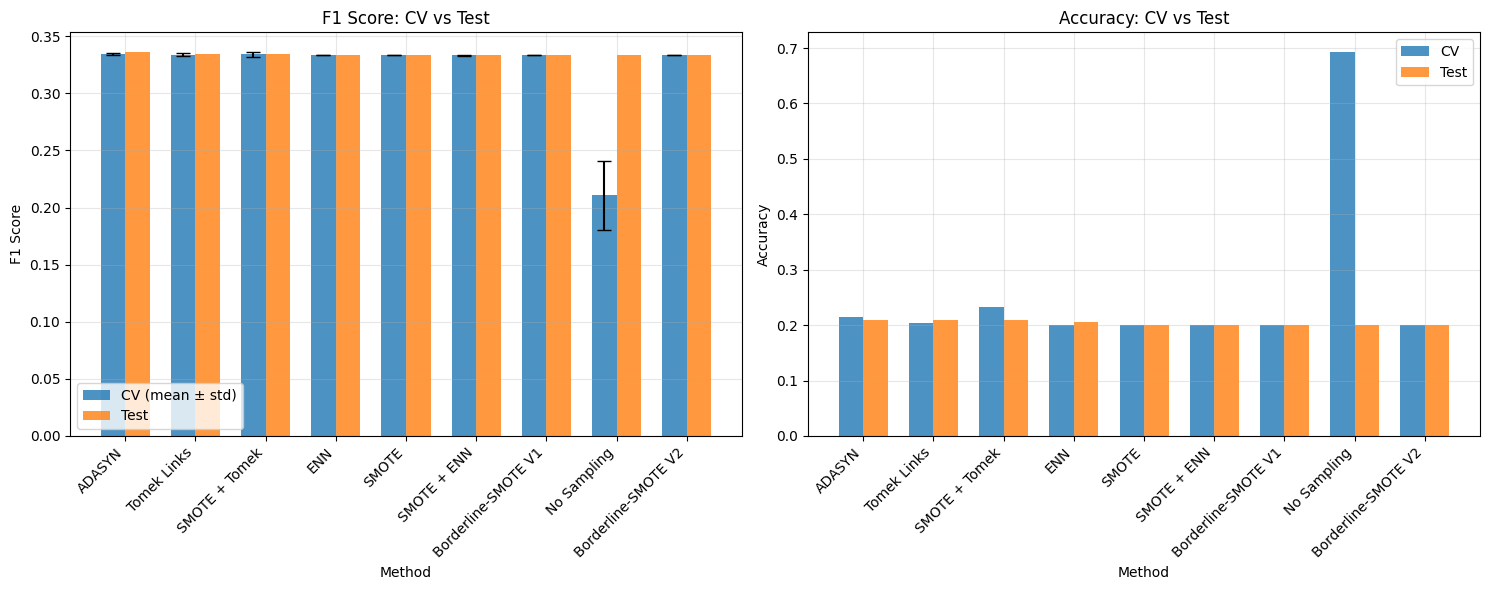

✅ Comparison table saved to: XGBoost_CV_Results/results/cv_vs_test_comparison.csv


In [21]:
# ============================================================================
# Cell 19: Cross-Validation vs Test Results
# ============================================================================

import pandas as pd
import matplotlib.pyplot as plt

print("\n" + "="*80)
print("📊 CROSS-VALIDATION vs TEST SET COMPARISON")
print("="*80)

# Prepare comparison data
comparison_data = []

for method_name in cv_results_all.keys():
    cv_summary = cv_results_all[method_name]['summary']
    test_metrics = test_results_all[method_name]
    
    comparison_data.append({
        'Method': method_name,
        'CV_F1': cv_summary['f1_mean'],
        'CV_F1_std': cv_summary['f1_std'],
        'Test_F1': test_metrics['f1'],
        'CV_Accuracy': cv_summary['accuracy_mean'],
        'Test_Accuracy': test_metrics['accuracy'],
        'CV_Recall': cv_summary['recall_mean'],
        'Test_Recall': test_metrics['recall'],
        'CV_Precision': cv_summary['precision_mean'],
        'Test_Precision': test_metrics['precision'],
    })

df_comparison = pd.DataFrame(comparison_data)

# Sort by Test F1
df_comparison_sorted = df_comparison.sort_values('Test_F1', ascending=False)

# Display table
print("\n📋 CV vs Test Performance:")
print("="*80)
print("\nF1 Score Comparison:")
for _, row in df_comparison_sorted.iterrows():
    cv_f1_str = f"{row['CV_F1']:.4f} ± {row['CV_F1_std']:.4f}"
    test_f1 = row['Test_F1']
    diff = test_f1 - row['CV_F1']
    diff_str = f"({diff:+.4f})"
    
    print(f"{row['Method']:25s}  CV: {cv_f1_str:15s}  Test: {test_f1:.4f}  {diff_str}")

# Check for overfitting
print("\n" + "="*80)
print("⚠️ OVERFITTING CHECK")
print("="*80)

for _, row in df_comparison_sorted.iterrows():
    cv_f1 = row['CV_F1']
    test_f1 = row['Test_F1']
    diff = test_f1 - cv_f1
    
    if diff < -0.05:  # Test performance worse by >5%
        status = "⚠️ Possible Overfitting"
    elif diff > 0.05:  # Test performance better by >5%
        status = "✅ Good Generalization"
    else:
        status = "✓ Stable"
    
    print(f"{row['Method']:25s}  Diff: {diff:+.4f}  {status}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# F1 Score comparison
methods = df_comparison_sorted['Method'].values
cv_f1 = df_comparison_sorted['CV_F1'].values
cv_f1_std = df_comparison_sorted['CV_F1_std'].values
test_f1 = df_comparison_sorted['Test_F1'].values

x = np.arange(len(methods))
width = 0.35

axes[0].bar(x - width/2, cv_f1, width, yerr=cv_f1_std, 
           label='CV (mean ± std)', alpha=0.8, capsize=5)
axes[0].bar(x + width/2, test_f1, width, 
           label='Test', alpha=0.8)
axes[0].set_xlabel('Method')
axes[0].set_ylabel('F1 Score')
axes[0].set_title('F1 Score: CV vs Test')
axes[0].set_xticks(x)
axes[0].set_xticklabels(methods, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy comparison
cv_acc = df_comparison_sorted['CV_Accuracy'].values
test_acc = df_comparison_sorted['Test_Accuracy'].values

axes[1].bar(x - width/2, cv_acc, width, label='CV', alpha=0.8)
axes[1].bar(x + width/2, test_acc, width, label='Test', alpha=0.8)
axes[1].set_xlabel('Method')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy: CV vs Test')
axes[1].set_xticks(x)
axes[1].set_xticklabels(methods, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plot_path = os.path.join(results_dir, 'cv_vs_test_comparison.png')
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"\n✅ Plot saved to: {plot_path}")
plt.show()

# Save comparison table
csv_path = os.path.join(results_dir, 'cv_vs_test_comparison.csv')
df_comparison_sorted.to_csv(csv_path, index=False)
print(f"✅ Comparison table saved to: {csv_path}")

In [22]:
# ============================================================================
# Cell 20: Final Summary & Recommendations
# ============================================================================

print("\n" + "="*80)
print("🎯 FINAL SUMMARY & RECOMMENDATIONS")
print("="*80)

# Best method by CV
df_cv_sorted = pd.DataFrame([r['summary'] for r in cv_results_all.values()])
df_cv_sorted = df_cv_sorted.sort_values('f1_mean', ascending=False)
best_cv_method = df_cv_sorted.iloc[0]['method']
best_cv_f1 = df_cv_sorted.iloc[0]['f1_mean']
best_cv_f1_std = df_cv_sorted.iloc[0]['f1_std']

print(f"\n🏆 BEST METHOD (by Cross-Validation):")
print(f"   Method: {best_cv_method}")
print(f"   CV F1 Score: {best_cv_f1:.4f} ± {best_cv_f1_std:.4f}")

# Best method by Test
df_test_sorted = pd.DataFrame(test_results_data)
df_test_sorted = df_test_sorted.sort_values('f1', ascending=False)
best_test_method = df_test_sorted.iloc[0]['method']
best_test_f1 = df_test_sorted.iloc[0]['f1']

print(f"\n🏆 BEST METHOD (on Test Set):")
print(f"   Method: {best_test_method}")
print(f"   Test F1 Score: {best_test_f1:.4f}")

# Consistency check
if best_cv_method == best_test_method:
    print(f"\n✅ CONSISTENT WINNER: {best_cv_method}")
    print("   Both CV and Test agree on the best method!")
else:
    print(f"\n⚠️ DIFFERENT WINNERS:")
    print(f"   CV best: {best_cv_method}")
    print(f"   Test best: {best_test_method}")
    print("   Consider both methods or ensemble approach.")

# Performance summary
print("\n" + "="*80)
print("📊 PERFORMANCE SUMMARY")
print("="*80)

print("\nTop 3 by CV F1 Score:")
for idx, row in df_cv_sorted.head(3).iterrows():
    print(f"  {idx+1}. {row['method']:25s}  {row['f1_mean']:.4f} ± {row['f1_std']:.4f}")

print("\nTop 3 by Test F1 Score:")
for idx, (_, row) in enumerate(df_test_sorted.head(3).iterrows(), 1):
    print(f"  {idx}. {row['method']:25s}  {row['f1']:.4f}")

print("\n" + "="*80)
print("✅ ANALYSIS COMPLETE!")
print("="*80)

print("\n📁 All results saved in:")
print(f"   {results_dir}/")


🎯 FINAL SUMMARY & RECOMMENDATIONS

🏆 BEST METHOD (by Cross-Validation):
   Method: ADASYN
   CV F1 Score: 0.3343 ± 0.0010

🏆 BEST METHOD (on Test Set):
   Method: ADASYN
   Test F1 Score: 0.3361

✅ CONSISTENT WINNER: ADASYN
   Both CV and Test agree on the best method!

📊 PERFORMANCE SUMMARY

Top 3 by CV F1 Score:
  5. ADASYN                     0.3343 ± 0.0010
  6. SMOTE + Tomek              0.3341 ± 0.0025
  8. Tomek Links                0.3337 ± 0.0013

Top 3 by Test F1 Score:
  1. ADASYN                     0.3361
  2. Tomek Links                0.3345
  3. SMOTE + Tomek              0.3342

✅ ANALYSIS COMPLETE!

📁 All results saved in:
   XGBoost_CV_Results/results/
